In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt

In [3]:
import os
import function_training
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import json

import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorboard.plugins.hparams import api as hp

from dataLoader import AnyDataset
import function_training
from function_training import confusion_matrix
# from config import args
from config import hyperparameters, args, CNN_model

numBands=100
bands_type="spin up"

Init Plugin
Init Graph Optimizer
Init Kernel


In [4]:
hyperparameters = {
        "learning_rate": 0.000005,
        "epochs": 600,
        "batch_size": 32,
}

In [5]:
# step 0. Check GPUs available:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))
# set device
device = tf.device('/GPU:0') if len(gpus) != 0 else tf.device('/CPU:0')

Num GPUs Available: 1
Metal device set to: Apple M1 Pro


In [56]:
# step 1. prepare dataset
def json2inputlabel(data_json, bands_type="spin up"):
    _bands_type = {"spin up": "spin_up_bands",
                   "spin down": "spin_down_bands",
                   "soc": "soc_bands"}
    data_input_np = np.array(data_json[_bands_type[bands_type]]) # 100 x 400
    print(data_input_np[:,165])
    # data_input_np = np.array(data_json[_bands_type[bands_type]]).flataten().T # 40000x1
    data_label_np = np.array([data_json["new_label"]])
    # data_label_np = np.array([data_json["layers_num"]])

    return data_input_np, data_label_np


#take data and set batch size here
train_dataset = AnyDataset("list/actual/train_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=True)
test_dataset = AnyDataset("list/actual/test_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=False)
train_loader = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs, train_dataset.data_labels)).shuffle(train_dataset.len).batch(hyperparameters['batch_size'])
test_loader = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(hyperparameters['batch_size'])


Loading train set:   0%|                                | 0/900 [00:00<?, ?it/s]


IndexError: index 165 is out of bounds for axis 1 with size 100

In [70]:
# with open("../../c2db_database02_output_eigenvalue_norm/c2db_AuCl2S2Sr2-2c3ca0de8040.json", "r") as file:
with open("../../c2db_database02/c2db_AuCl2S2Sr2-2c3ca0de8040.json", "r") as file:
    data_json = json.load(file)

In [76]:
np.array(data_json["bands"]["nonsoc_energies"]["bands"]).shape

(1, 400, 48)

In [69]:
np.array(data_json['bands']['nonsoc_energies']).shape

()

In [59]:
for pts in data_json["k_labels"]:
#     if pts[0] == 'G':
        print (pts[0], pts[1])
        high_symmetry_pts_index = pts[1]
#         break

M 0
G 165
X 282
M 399


In [7]:
# train_dataset.data_inputs[0][0]
train_dataset_input = np.array(train_dataset.data_inputs)
test_dataset_input = np.array(test_dataset.data_inputs)

In [24]:
train_dataset_input[0][:,0].shape

(60,)

## test ended ##

In [7]:
train_dataset_labels = np.array(train_dataset.data_labels).reshape(900,)
test_dataset_labels = np.array(test_dataset.data_labels).reshape(100,)

In [8]:
# idx = np.random.permutation(len(data))
# x,y = data[idx], classes[idx]

In [9]:
# MLP_model = [
#     tf.keras.layers.Flatten(input_shape=(60, 100)),
#     # tf.keras.layers.Flatten(input_shape=(60, 400)),
#     tf.keras.layers.LeakyReLU(),

#     tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(3125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),


#     tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),


#     tf.keras.layers.Dense(5),
#     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Softmax()
# ]
# MLP_model = [
#     tf.keras.layers.Flatten(input_shape=(60, 100)),
#     # tf.keras.layers.Flatten(input_shape=(60, 400)),
#     tf.keras.layers.LeakyReLU(),

# #     tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
# #                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
# #                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
# #     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Dropout(0.3),
    
    
#     tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

# #     tf.keras.layers.Dense(375, use_bias=True, bias_initializer='zeros',
# #                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
# #                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
# #     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Dropout(0.3),


#     tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

# #     tf.keras.layers.Dense(25, use_bias=True, bias_initializer='zeros',
# #                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
# #                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
# #     tf.keras.layers.LeakyReLU(),


#     tf.keras.layers.Dense(5),
#     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Softmax()
# ]

MLP_model = [
    tf.keras.layers.Flatten(input_shape=(60, 100)),
    # tf.keras.layers.Flatten(input_shape=(60, 400)),
    tf.keras.layers.LeakyReLU(),

#     tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),
    
    
    tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(5000, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),


    tf.keras.layers.Dense(500, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),


    tf.keras.layers.Dense(5),
    tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Softmax()
]
# MLP_model = [
#     tf.keras.layers.Flatten(input_shape=(60, 100)),
#     # tf.keras.layers.Flatten(input_shape=(60, 400)),
#     tf.keras.layers.LeakyReLU(),

# #     tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
# #                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
# #                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
# #     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Dropout(0.3),
    
    
#     tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(3125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),


#     tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),


#     tf.keras.layers.Dense(5),
#     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Softmax()
# ]

In [10]:
# step 2. build model
model = tf.keras.Sequential(MLP_model)

# step 3. define loss
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# # step 4. Model compile
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=hyperparameters['learning_rate'],
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# step 5. select metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [11]:
# step 6. train & evaluate & save model
losses_train, accuracy_train, losses_test, accuracy_test, model = function_training.train_it(device, model, "./state_dicts/",
                                                                                      hyperparameters['epochs'],train_loader, test_loader, loss_fn, optimizer,
                                                                                      train_loss, train_accuracy, test_loss, test_accuracy,
                                                                                      eval_num_epochs=1, numClasss=args["load"]["numClasses"])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 6000)              0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 625)               3750625   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 625)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 625)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5000)              3130000   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 5000)              0

2022-06-10 22:09:45.115451: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1 | Loss:   4.147243976593018 | Accuracy (%):   20.666667938232422
	Test Loss:  1.5723164081573486  |  Test Accuracy (%): 33.0
Epoch 2 | Loss:   2.1898748874664307 | Accuracy (%):   29.11111068725586
	Test Loss:  1.6182035207748413  |  Test Accuracy (%): 28.0
Epoch 3 | Loss:   1.8513294458389282 | Accuracy (%):   34.11111068725586
	Test Loss:  1.3976608514785767  |  Test Accuracy (%): 48.0
Epoch 4 | Loss:   1.6713305711746216 | Accuracy (%):   36.111114501953125
	Test Loss:  1.2966368198394775  |  Test Accuracy (%): 44.0
Epoch 5 | Loss:   1.6060467958450317 | Accuracy (%):   38.333335876464844
	Test Loss:  1.5425584316253662  |  Test Accuracy (%): 42.999996185302734
Epoch 6 | Loss:   1.4654790163040161 | Accuracy (%):   43.111114501953125
	Test Loss:  1.3518667221069336  |  Test Accuracy (%): 44.0
Epoch 7 | Loss:   1.406160831451416 | Accuracy (%):   44.11111068725586
	Test Loss:  1.3125309944152832  |  Test Accuracy (%): 47.0
Epoch 8 | Loss:   1.392881155014038 | Accuracy (%):  

Epoch 62 | Loss:   1.0576114654541016 | Accuracy (%):   59.11111068725586
	Test Loss:  1.101204514503479  |  Test Accuracy (%): 53.999996185302734
Epoch 63 | Loss:   1.0884534120559692 | Accuracy (%):   59.11111068725586
	Test Loss:  1.37692391872406  |  Test Accuracy (%): 52.999996185302734
Epoch 64 | Loss:   1.0490995645523071 | Accuracy (%):   59.66666793823242
	Test Loss:  1.3936911821365356  |  Test Accuracy (%): 52.0
Epoch 65 | Loss:   1.0738312005996704 | Accuracy (%):   57.4444465637207
	Test Loss:  1.2787766456604004  |  Test Accuracy (%): 52.0
Epoch 66 | Loss:   1.0257877111434937 | Accuracy (%):   60.888893127441406
	Test Loss:  1.1992708444595337  |  Test Accuracy (%): 52.999996185302734
Epoch 67 | Loss:   1.0516221523284912 | Accuracy (%):   59.66666793823242
	Test Loss:  1.2532589435577393  |  Test Accuracy (%): 52.999996185302734
Epoch 68 | Loss:   1.0229955911636353 | Accuracy (%):   59.66666793823242
	Test Loss:  1.1894795894622803  |  Test Accuracy (%): 52.99999618530

Epoch 121 | Loss:   0.9103378653526306 | Accuracy (%):   65.55555725097656
	Test Loss:  1.1396641731262207  |  Test Accuracy (%): 57.0
Epoch 122 | Loss:   0.9004353284835815 | Accuracy (%):   64.0
	Test Loss:  1.0204399824142456  |  Test Accuracy (%): 53.999996185302734
Epoch 123 | Loss:   1.0104008913040161 | Accuracy (%):   64.55555725097656
	Test Loss:  1.3119919300079346  |  Test Accuracy (%): 52.999996185302734
Epoch 124 | Loss:   0.9329033493995667 | Accuracy (%):   66.66667175292969
	Test Loss:  1.2649370431900024  |  Test Accuracy (%): 56.0
Epoch 125 | Loss:   0.9126483201980591 | Accuracy (%):   64.88888549804688
	Test Loss:  1.084755778312683  |  Test Accuracy (%): 50.0
Epoch 126 | Loss:   0.8853828310966492 | Accuracy (%):   65.0
	Test Loss:  1.4229609966278076  |  Test Accuracy (%): 53.999996185302734
Epoch 127 | Loss:   0.9219399690628052 | Accuracy (%):   66.11111450195312
	Test Loss:  0.9915438890457153  |  Test Accuracy (%): 57.0
Epoch 128 | Loss:   0.8608447909355164 |

Epoch 182 | Loss:   0.8167484402656555 | Accuracy (%):   70.66667175292969
	Test Loss:  1.2051078081130981  |  Test Accuracy (%): 56.0
Epoch 183 | Loss:   0.7913341522216797 | Accuracy (%):   71.33333587646484
	Test Loss:  1.0654661655426025  |  Test Accuracy (%): 56.0
Epoch 184 | Loss:   0.7738330960273743 | Accuracy (%):   71.88888549804688
	Test Loss:  1.1286240816116333  |  Test Accuracy (%): 58.0
Epoch 185 | Loss:   0.8229637145996094 | Accuracy (%):   69.44445037841797
	Test Loss:  1.046446681022644  |  Test Accuracy (%): 56.0
Epoch 186 | Loss:   0.8004193305969238 | Accuracy (%):   70.11111450195312
	Test Loss:  1.256087303161621  |  Test Accuracy (%): 56.0
Epoch 187 | Loss:   0.7798177003860474 | Accuracy (%):   71.33333587646484
	Test Loss:  1.2105844020843506  |  Test Accuracy (%): 57.0
Epoch 188 | Loss:   0.798565685749054 | Accuracy (%):   70.22222137451172
	Test Loss:  1.3051741123199463  |  Test Accuracy (%): 55.0
Epoch 189 | Loss:   0.7802655696868896 | Accuracy (%):   7

Epoch 243 | Loss:   0.789417028427124 | Accuracy (%):   73.11111450195312
	Test Loss:  1.2310097217559814  |  Test Accuracy (%): 57.0
Epoch 244 | Loss:   0.7948876619338989 | Accuracy (%):   70.77777862548828
	Test Loss:  1.0921894311904907  |  Test Accuracy (%): 53.999996185302734
Epoch 245 | Loss:   0.6837190985679626 | Accuracy (%):   73.22222900390625
	Test Loss:  1.1636496782302856  |  Test Accuracy (%): 55.0
Epoch 246 | Loss:   0.7229065895080566 | Accuracy (%):   73.77777862548828
	Test Loss:  1.1497564315795898  |  Test Accuracy (%): 57.0
Epoch 247 | Loss:   0.7243779897689819 | Accuracy (%):   73.8888931274414
	Test Loss:  1.5155668258666992  |  Test Accuracy (%): 57.0
Epoch 248 | Loss:   0.6732094883918762 | Accuracy (%):   74.1111068725586
	Test Loss:  1.1628978252410889  |  Test Accuracy (%): 57.0
Epoch 249 | Loss:   0.765769362449646 | Accuracy (%):   71.88888549804688
	Test Loss:  1.344905138015747  |  Test Accuracy (%): 56.0
Epoch 250 | Loss:   0.7309130430221558 | Accur

Epoch 304 | Loss:   0.6216283440589905 | Accuracy (%):   76.55555725097656
	Test Loss:  1.1664435863494873  |  Test Accuracy (%): 58.0
Epoch 305 | Loss:   0.6600460410118103 | Accuracy (%):   75.77777862548828
	Test Loss:  1.57895827293396  |  Test Accuracy (%): 58.0
Epoch 306 | Loss:   0.6211102604866028 | Accuracy (%):   77.77777862548828
	Test Loss:  1.29296875  |  Test Accuracy (%): 58.0
Epoch 307 | Loss:   0.6255488395690918 | Accuracy (%):   76.44445037841797
	Test Loss:  1.1261940002441406  |  Test Accuracy (%): 59.999996185302734
Epoch 308 | Loss:   0.6980478763580322 | Accuracy (%):   77.55555725097656
	Test Loss:  1.39216947555542  |  Test Accuracy (%): 52.999996185302734
Epoch 309 | Loss:   0.6778539419174194 | Accuracy (%):   77.33333587646484
	Test Loss:  1.4078078269958496  |  Test Accuracy (%): 55.0
Epoch 310 | Loss:   0.6217827796936035 | Accuracy (%):   76.22222137451172
	Test Loss:  1.4459521770477295  |  Test Accuracy (%): 56.0
Epoch 311 | Loss:   0.6626869440078735 

Epoch 364 | Loss:   0.5650373101234436 | Accuracy (%):   76.55555725097656
	Test Loss:  1.1435682773590088  |  Test Accuracy (%): 55.0
Epoch 365 | Loss:   0.5880773663520813 | Accuracy (%):   77.88888549804688
	Test Loss:  1.6753387451171875  |  Test Accuracy (%): 56.0
Epoch 366 | Loss:   0.5728750824928284 | Accuracy (%):   78.66667175292969
	Test Loss:  1.5008916854858398  |  Test Accuracy (%): 56.0
Epoch 367 | Loss:   0.5534893274307251 | Accuracy (%):   80.22222900390625
	Test Loss:  1.4251179695129395  |  Test Accuracy (%): 52.999996185302734
Epoch 368 | Loss:   0.5269124507904053 | Accuracy (%):   80.55555725097656
	Test Loss:  1.345542073249817  |  Test Accuracy (%): 56.0
Epoch 369 | Loss:   0.5568661093711853 | Accuracy (%):   78.22222900390625
	Test Loss:  1.5507020950317383  |  Test Accuracy (%): 53.999996185302734
Epoch 370 | Loss:   0.5477615594863892 | Accuracy (%):   80.22222900390625
	Test Loss:  1.5569875240325928  |  Test Accuracy (%): 56.0
Epoch 371 | Loss:   0.555638

Epoch 425 | Loss:   0.4878532886505127 | Accuracy (%):   80.22222900390625
	Test Loss:  2.0564992427825928  |  Test Accuracy (%): 55.0
Epoch 426 | Loss:   0.47336050868034363 | Accuracy (%):   81.22222137451172
	Test Loss:  1.400654911994934  |  Test Accuracy (%): 58.0
Epoch 427 | Loss:   0.5113813281059265 | Accuracy (%):   81.55555725097656
	Test Loss:  1.2837564945220947  |  Test Accuracy (%): 52.999996185302734
Epoch 428 | Loss:   0.4916202127933502 | Accuracy (%):   81.33333587646484
	Test Loss:  1.957658290863037  |  Test Accuracy (%): 58.0
Epoch 429 | Loss:   0.47480136156082153 | Accuracy (%):   83.44444274902344
	Test Loss:  1.3422290086746216  |  Test Accuracy (%): 57.0
Epoch 430 | Loss:   0.4702487587928772 | Accuracy (%):   82.77777862548828
	Test Loss:  1.4118725061416626  |  Test Accuracy (%): 58.0
Epoch 431 | Loss:   0.5126230120658875 | Accuracy (%):   79.77777862548828
	Test Loss:  1.3534667491912842  |  Test Accuracy (%): 57.0
Epoch 432 | Loss:   0.49560970067977905 |

Epoch 485 | Loss:   0.4345621168613434 | Accuracy (%):   84.22222137451172
	Test Loss:  1.6953201293945312  |  Test Accuracy (%): 55.0
Epoch 486 | Loss:   0.4293830096721649 | Accuracy (%):   83.77777862548828
	Test Loss:  1.4459869861602783  |  Test Accuracy (%): 55.0
Epoch 487 | Loss:   0.4635678827762604 | Accuracy (%):   83.33333587646484
	Test Loss:  1.5831260681152344  |  Test Accuracy (%): 55.0
Epoch 488 | Loss:   0.4134330451488495 | Accuracy (%):   83.55555725097656
	Test Loss:  1.3432363271713257  |  Test Accuracy (%): 55.0
Epoch 489 | Loss:   0.4227764904499054 | Accuracy (%):   83.88888549804688
	Test Loss:  1.4175708293914795  |  Test Accuracy (%): 58.0
Epoch 490 | Loss:   0.4395972192287445 | Accuracy (%):   83.55555725097656
	Test Loss:  1.3179407119750977  |  Test Accuracy (%): 58.999996185302734
Epoch 491 | Loss:   0.429083913564682 | Accuracy (%):   85.22222900390625
	Test Loss:  1.8031748533248901  |  Test Accuracy (%): 58.0
Epoch 492 | Loss:   0.4346344470977783 | A

Epoch 545 | Loss:   0.4133901596069336 | Accuracy (%):   83.55555725097656
	Test Loss:  1.9344382286071777  |  Test Accuracy (%): 58.999996185302734
Epoch 546 | Loss:   0.3801322281360626 | Accuracy (%):   86.66666412353516
	Test Loss:  1.5835485458374023  |  Test Accuracy (%): 56.0
Epoch 547 | Loss:   0.4042607247829437 | Accuracy (%):   85.33333587646484
	Test Loss:  2.512955904006958  |  Test Accuracy (%): 53.999996185302734
Epoch 548 | Loss:   0.42571938037872314 | Accuracy (%):   84.55555725097656
	Test Loss:  1.4245747327804565  |  Test Accuracy (%): 57.0
Epoch 549 | Loss:   0.38758957386016846 | Accuracy (%):   85.33333587646484
	Test Loss:  1.5243244171142578  |  Test Accuracy (%): 53.999996185302734
Epoch 550 | Loss:   0.3815886676311493 | Accuracy (%):   86.55555725097656
	Test Loss:  1.4220232963562012  |  Test Accuracy (%): 56.0
Epoch 551 | Loss:   0.4032355546951294 | Accuracy (%):   84.55555725097656
	Test Loss:  1.7356178760528564  |  Test Accuracy (%): 57.0
Epoch 552 | 

2022-06-10 22:13:10.745077: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./state_dicts/assets


In [12]:
test_loader2 = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(train_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in test_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])
    predict = np.argmax(model.predict(element), axis=-1)
    label = np.array(labels).flatten()
#     print (f"model {model.predict_classes(element)}, actual {labels}")
#     model.predict_classes(element)
    break


In [13]:
# m = tf.keras.metrics.Accuracy()
# m.update_state(label, predict)
# m.result().numpy()


from sklearn.metrics import accuracy_score
mse = accuracy_score(y_true=label, y_pred=predict)
mse

0.59

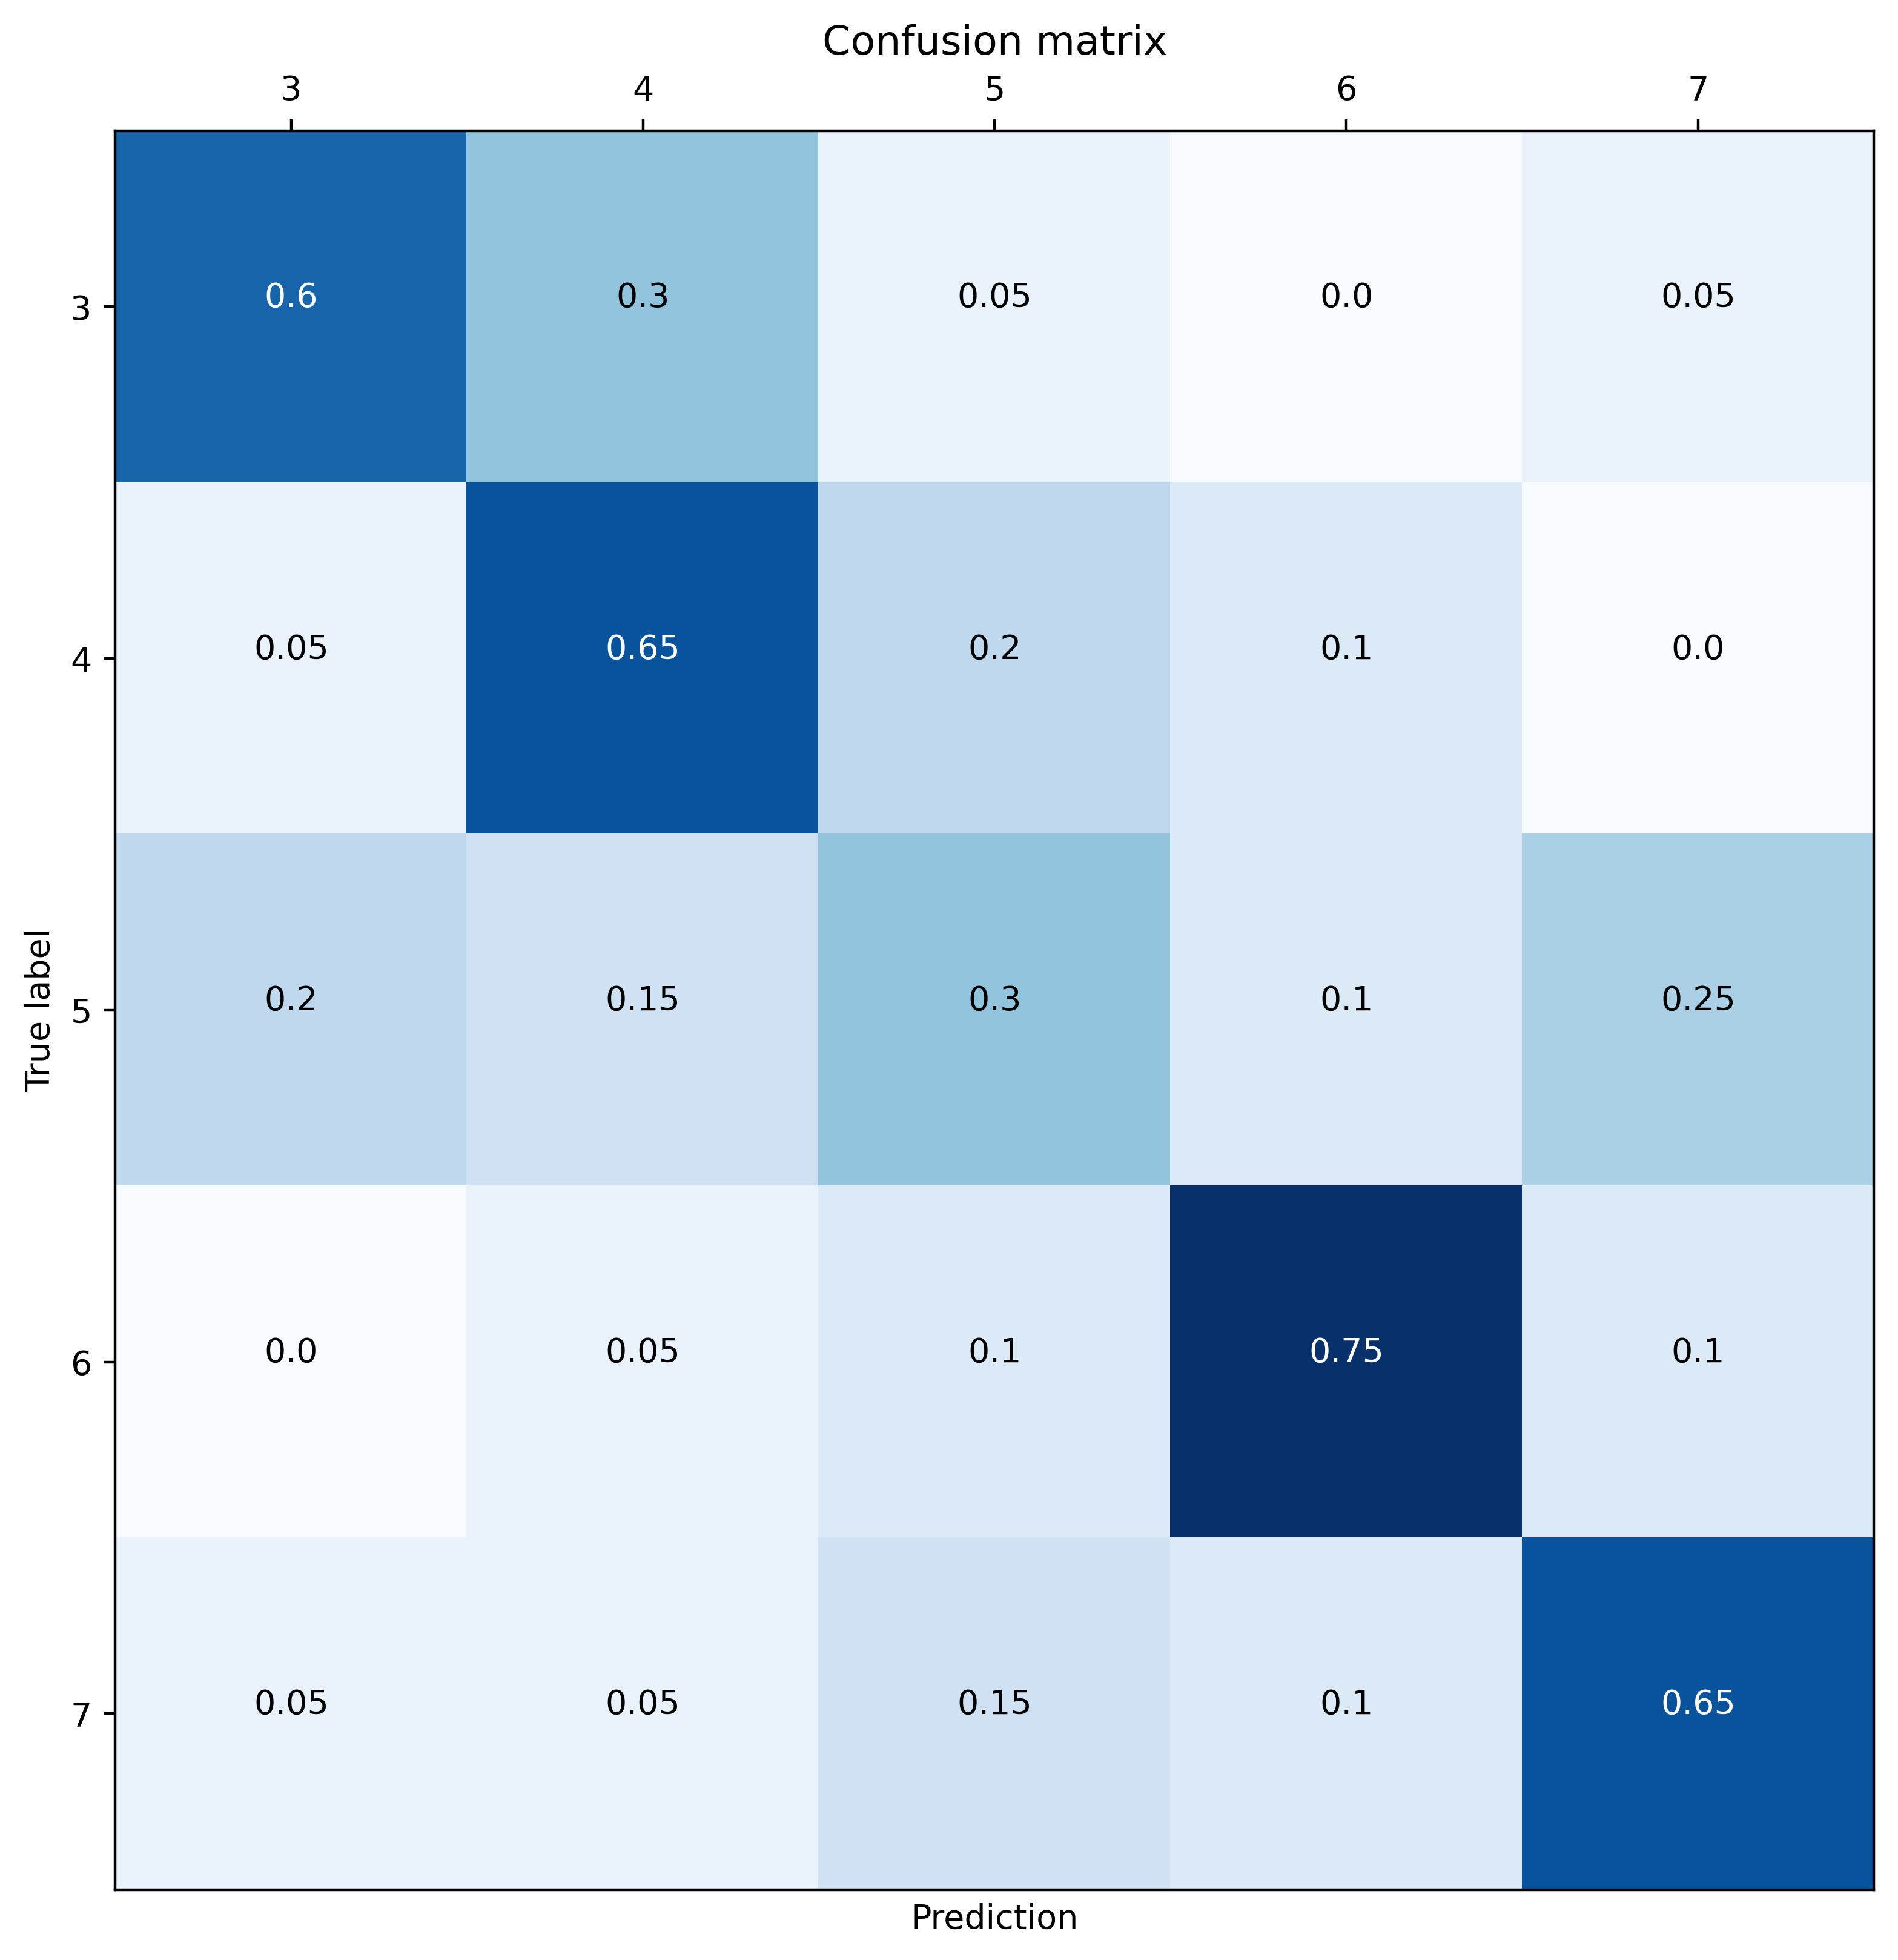

In [14]:
confusion_matrix(labels=label, predictions=predict, class_names=[3, 4, 5, 6, 7])